In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# En funktion så man kan se hele dataframen (pas på med dette da det nemt kan crashe)
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    display(x)
    pd.reset_option('display.max_rows')

In [3]:
# Loader text filen med simulations resultater teksten i '' er filnavn til simulation
Sim = pd.read_csv('Sim_2035_1985.txt', sep="\t", index_col="hour")

# det her renser dataframen lidt det behøves ik ændres i
if 'Unnamed: 404' in Sim.columns and Sim['Unnamed: 404'].isnull().all():
    Sim = Sim.drop('Unnamed: 404', axis=1)

In [4]:
#Hvis man er interesser i at se hvordan dataframen ser ud før den er behandlet (fjern #)
#Sim

In [5]:
def plot(x_data, y_data, title=None, freq=None, start=None, end=None):
    """
    plot data med givne x og y værdier.

    Parametere:
        x_data (array or array-like): Data til x akse.
        y_data (array or array-like): Data til y akse.
        title (str): Title til plottet.
        freq (int): Dette er en multiplikator effekt. hvis den er sat til f.eks. 24 så summere den per 24 timer
        start (int): Start timen.
        end (int): Slut timen.
    """
    
    x_data = pd.to_datetime(x_data, unit='h', origin=pd.Timestamp('2022-01-01'))
    x_num = np.arange(len(x_data)) # create an array of integers from 0 to the length of x_data
    
    if freq is None:
        # Plot all data points
        x = x_num[start:end]
        y = y_data[start:end]
        plt.plot(x, y)
    else:
        # Resample y_data based on the specified frequency
        grouped_data = pd.DataFrame({'x': x_data, 'y': y_data}).set_index('x').resample(f"{freq}H").sum().reset_index()
        start_index = start // freq
        end_index = end // freq
        x = np.arange(len(grouped_data))[start_index:end_index]
        y = grouped_data['y'][start_index:end_index]
        plt.plot(x, y)
    
    plt.xlabel('X Data')
    plt.ylabel(y_data.name if hasattr(y_data, 'name') else 'Y Data')
    plt.title(title if title else 'Dynamic Range Plot')
    plt.autoscale(enable=True, axis='both', tight=True)
    
    plt.show()

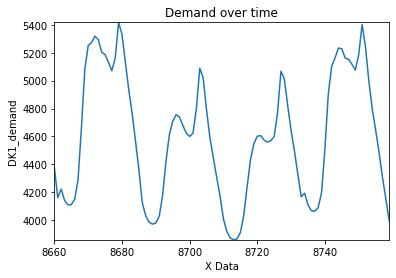

In [6]:
# Her vælges timen som x akse (Sim.index er timer), derudover er demand i DK1 valgt som y væriden
# Dette kan ændres til alle kolonne værdier med at ændre til Sim['KOLLONE MAN VIL UNDERSØGE']
# freq kan også ændres, ved None vil det bare hver pr. time. tiden der er valgt at kigge på er de sidste 100 timer
plot(Sim.index, Sim['DK1_demand'], title='Demand over time', freq=None, start=8660, end=8760)

In [7]:
# Her undrsøger jeg om der er EENS i de tre lande som ekspoterer massere af energi
print(f'Total EENS NOs: {Sim["NOs_EENS"].sum()}')
print(f'Total EENS GB: {Sim["GB_EENS"].sum()}')
print(f'Total EENS NL: {Sim["NL_EENS"].sum()}')

Total EENS NOs: 0.0105999999999999
Total EENS GB: 0.0
Total EENS NL: 10884.5396


In [8]:
# Her undrsøger jeg om der er EENS i de tre lande som ekspoterer massere af energi
print(f'Total EENS DK1: {Sim["DK1_EENS"].sum()}')
print(f'Total EENS DK2: {Sim["DK2_EENS"].sum()}')

Total EENS DK1: 11277.435
Total EENS DK2: 17683.729900000002


In [9]:
# I den her blok undersøger jeg hvad den højeste time værdi af EENS er i holland samt 
# undersøger hvor mange gange den er positiv
# dette er lidt et levn fra dengang NL havde meget lav energi produktion og halv ligegyldigt nu
max_NL_EENS = Sim['NL_EENS'].max()
idxmax_NL_EENS = Sim['NL_EENS'].idxmax()

print(f'The highest NL_EENS is {max_NL_EENS:.2f} and occurs at hour {idxmax_NL_EENS}.')

# hvor mange gange er den psoitiv
num_positive = (Sim['NL_EENS'] > 0).sum()
print(f"NL_EENS is positive {num_positive} times.")

The highest NL_EENS is 2209.09 and occurs at hour 8249.
NL_EENS is positive 480 times.


In [10]:
# Det næste stykke bliver brugt til at finde hvornår der er lav energi perioder. det som bliver defineret som
# Nodes er de lande (deres zoner) som jeg summere over og tjekker energi for.
nodes = ['DK1', 'DK2', 'DKBO', 'DKKF', 'DKEI', 'NOn', 'NOm', 'NOs', 'SE1', 'SE2', 'SE3', 'SE4', 'DELU']
cols = ['Wind', 'Solar']
Sim_nodes = Sim.loc[:, [(node + '_' + col) for node in nodes for col in cols if (node + '_' + col) in Sim.columns]]

In [11]:
# Her summerer jeg over alle perioderne
hourly_energy = Sim_nodes.sum(axis=1)

# vælger et threshold for hvad der skal være grænsen af hvad der bliver defineret som en arbitrær værdi.
# dette kan vælges indtil man har så mange periode man ønsker
threshold = 5430000
length = 120 # her er længden valgt til 5 dage 5*24=120

In [12]:
low_periods = [] #Først laves en tom dictionary
for i in range(len(hourly_energy) - (length-1)): # Looper gennem alle timer hvor der er længden tilbage (så  
    # der kan være hele perioder på hele længden
    total_energy = sum(hourly_energy[i:i+length]) # summer energien for hele perioden
    if total_energy < threshold: #Hvis summen er mindre end threhold fortsætte loopet
        i_range = range(i, i+length)  # Opret et range objekt, der går fra i til i+length.
        if all(i not in low_periods for low_periods in low_periods for i in i_range):  # Tjek om alle i i i_range ikke 
        # er i nogen af de tidligere perioder.
            low_periods.append((i, i+(length-1)))  # Tilføj den nuværende periode (i til i+length-1) til 
            #listen af perioder.

In [13]:
# Denne her kodeblok printer hver af de perioder med lav energy produktion og print derefter den samlede
for period in low_periods:
    energy_production = Sim_nodes.iloc[period[0]:min(period[0]+119, period[1])+1].sum().sum()
    print(f"Low energy production period from hour {period[0]} to {period[0]+119}. Total energy production: {energy_production:.2f}.")

Low energy production period from hour 805 to 924. Total energy production: 5405577.33.
Low energy production period from hour 1290 to 1409. Total energy production: 5418925.67.
Low energy production period from hour 1492 to 1611. Total energy production: 5362738.17.
Low energy production period from hour 4088 to 4207. Total energy production: 5418609.19.
Low energy production period from hour 5425 to 5544. Total energy production: 5428499.94.
Low energy production period from hour 6334 to 6453. Total energy production: 5395780.73.
Low energy production period from hour 7149 to 7268. Total energy production: 5377111.09.
Low energy production period from hour 7549 to 7668. Total energy production: 5347773.75.
Low energy production period from hour 7758 to 7877. Total energy production: 5396026.13.
Low energy production period from hour 8155 to 8274. Total energy production: 5423160.81.


In [14]:
# denne her kodeblok er et værktøj til at danne en ny dataframe som kun indeholder de efter spurgte områder
# og det er isoleret kun til de perioder med lav energi
# områderne inkluderet kan nemt ændre. enten slette eller tilføje nye
cols_to_keep = Sim.filter(like='DK1').columns.tolist() + \
               Sim.filter(like='DK2').columns.tolist() + \
               Sim.filter(like='DKBO').columns.tolist() + \
               Sim.filter(like='DKKF').columns.tolist() + \
               Sim.filter(like='DKEI').columns.tolist() + \
               Sim.filter(like='NOn').columns.tolist() + \
               Sim.filter(like='NOm').columns.tolist() + \
               Sim.filter(like='NOs').columns.tolist() + \
               Sim.filter(like='SE1').columns.tolist() + \
               Sim.filter(like='SE2').columns.tolist() + \
               Sim.filter(like='SE3').columns.tolist() + \
               Sim.filter(like='SE4').columns.tolist() + \
               Sim.filter(like='DELU').columns.tolist()

cols_to_keep = [*set(cols_to_keep)]
# subset the dataframe to keep only the relevant columns
Sim_subset = Sim[cols_to_keep]

In [15]:
# denne kodeblok danner så den nye dataframe som sagt kun indeholder de områder samt lav energi periode
low_energy_rows_focus = pd.DataFrame()
for period in low_periods:
    low_energy_rows_focus = pd.concat([low_energy_rows_focus, Sim_subset.loc[period[0]:period[1]]])

In [16]:
#Fjerner dupliketter
low_energy_rows_focus = low_energy_rows_focus.loc[:, ~low_energy_rows_focus.columns.duplicated()]

In [17]:
#Nu er der dannet en dataframe kun med lav energi perioder så kan jeg feks kigge på DK1s vind porduktion,
#sol produktion og demand
for period in low_periods:
    print(f"period from hour {period[0]} to {period[0]+119}. DK1_demand: {low_energy_rows_focus.loc[period[0]:period[0]+119, 'DK1_demand'].sum():.2f}. DK1_Wind: {low_energy_rows_focus.loc[period[0]:period[0]+119, 'DK1_Wind'].sum():.2f}. DK1_Solar: {low_energy_rows_focus.loc[period[0]:period[0]+119, 'DK1_Solar'].sum():.2f}.")

period from hour 805 to 924. DK1_demand: 574212.14. DK1_Wind: 236073.76. DK1_Solar: 32503.64.
period from hour 1290 to 1409. DK1_demand: 537636.99. DK1_Wind: 175411.37. DK1_Solar: 35886.47.
period from hour 1492 to 1611. DK1_demand: 561673.75. DK1_Wind: 206540.34. DK1_Solar: 64439.68.
period from hour 4088 to 4207. DK1_demand: 504148.00. DK1_Wind: 95938.46. DK1_Solar: 157396.86.
period from hour 5425 to 5544. DK1_demand: 507431.32. DK1_Wind: 117048.57. DK1_Solar: 135782.78.
period from hour 6334 to 6453. DK1_demand: 517971.68. DK1_Wind: 84055.95. DK1_Solar: 86808.01.
period from hour 7149 to 7268. DK1_demand: 532065.57. DK1_Wind: 214784.25. DK1_Solar: 50778.20.
period from hour 7549 to 7668. DK1_demand: 571019.49. DK1_Wind: 255679.01. DK1_Solar: 46160.15.
period from hour 7758 to 7877. DK1_demand: 566440.23. DK1_Wind: 358921.79. DK1_Solar: 17435.99.
period from hour 8155 to 8274. DK1_demand: 557218.61. DK1_Wind: 154158.36. DK1_Solar: 17432.19.


## Herefter kunne man lave nogle flere figurer eller udskrifter for at analysere lav energi perioderne

In [18]:
# her gøres det samme men kun for holland, dette er fordi holland har så høj eksport (Havde ihvertfald)
cols_to_keep_NL = Sim.filter(like='NL').columns.tolist()

# subset the dataframe to keep only the relevant columns
Sim_subset_NL = Sim[cols_to_keep_NL]

In [19]:
# danner den nye dataframe med fokus på holland og lav energi perioder
low_energy_rows_NL = pd.DataFrame()
for period in low_periods:
    low_energy_rows_NL = pd.concat([low_energy_rows_NL, Sim_subset_NL.loc[period[0]:period[1]]])

In [20]:
# For at undersøge eksporten og importen mellem holland og de områder der er fobundet oprettes to nye
# kolonne i min holland fokuseret dataframe
Sim_subset_NL_copy = Sim_subset_NL.copy()
Sim_subset_NL_copy.loc[:, 'NL_export'] = ((Sim_subset_NL_copy[['NL_to_BE', 'NL_to_GB']].clip(lower=0).sum(axis=1)) - 
                                    (Sim_subset_NL_copy[['DK1_to_NL', 'NOs_to_NL', 'DELU_to_NL']].clip(upper=0).sum(axis=1)))
Sim_subset_NL_copy.loc[:, 'NL_import'] = (-Sim_subset_NL_copy[['NL_to_BE', 'NL_to_GB']].clip(upper=0).sum(axis=1)
                              + Sim_subset_NL_copy[['DK1_to_NL', 'NOs_to_NL', 'DELU_to_NL']].clip(lower=0).sum(axis=1))
Sim_subset_NL=Sim_subset_NL_copy
del Sim_subset_NL_copy

In [21]:
# vil lige se om tallene passer
print(f'Total NL export: {Sim_subset_NL["NL_export"].sum()}')
print(f'Total NL import: {Sim_subset_NL["NL_import"].sum()}')

Total NL export: 12877273.6138
Total NL import: 3515032.471


Holland ekspoterer rigtig meget energi og impotere også en del. alligevel er deres EENS så høj. virker spøjst

In [22]:
#Her isolere jeg de tidspunkter hvor holland impotere energi. det er fra det gamle data da holland nærmest
#impoterede ingenting
Sim_subset_NL_import = Sim_subset_NL[Sim_subset_NL['NL_import'] > 0]